In [1]:
# ESG Analysis using BERT Model
import os
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel, pipeline
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("BERT ESG Analysis Setup")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Configure device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/Users/wenlong/Documents/GitHub/ESG---AI-ML/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BERT ESG Analysis Setup
PyTorch version: 2.7.1
CUDA available: False
Using device: cpu


In [2]:
# Load Company Data (same structure as BOW model)
def load_company_documents():
    """Load all company documents from structured directories"""
    data_dir = "data"
    companies = ['apple', 'tesla', 'google', 'microsoft', 'nike', 'fedex']
    
    company_texts = {}
    company_documents = {}  # Store documents separately for BERT processing
    
    for company in companies:
        company_dir = os.path.join(data_dir, company)
        if not os.path.exists(company_dir):
            print(f"Warning: {company_dir} not found")
            continue
            
        # Store all documents separately for semantic analysis
        documents = []
        all_text = ""
        doc_count = 0
        
        # Load 10-K documents
        for item in ['10k_item1.md', '10k_item1A.md', '10k_item7.md', '10k_item7A.md']:
            file_path = os.path.join(company_dir, item)
            if os.path.exists(file_path):
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read()
                    documents.append({'type': '10k', 'item': item, 'content': content})
                    all_text += content + "\n\n"
                    doc_count += 1
        
        # Load ESG report
        esg_path = os.path.join(company_dir, 'ESG_Report.md')
        if os.path.exists(esg_path):
            with open(esg_path, 'r', encoding='utf-8') as f:
                content = f.read()
                documents.append({'type': 'esg', 'item': 'ESG_Report', 'content': content})
                all_text += content + "\n\n"
                doc_count += 1
        
        company_texts[company] = all_text
        company_documents[company] = documents
        print(f"{company.title()}: {doc_count} documents loaded, {len(all_text):,} characters")
    
    return company_texts, company_documents

# Load company data
company_texts, company_documents = load_company_documents()

# Initialize BERT models
print("\nInitializing BERT models...")

# Use sentence-transformers for better semantic embeddings
model_name = 'all-MiniLM-L6-v2'  # Lightweight but effective
sentence_model = SentenceTransformer(model_name)

# Also initialize a classification pipeline for sentiment/ESG topic classification
classifier = pipeline("zero-shot-classification", 
                     model="facebook/bart-large-mnli",
                     device=0 if torch.cuda.is_available() else -1)

print(f"BERT models initialized successfully!")
print(f"Sentence model: {model_name}")
print(f"Classification model: facebook/bart-large-mnli")

Apple: 5 documents loaded, 497,893 characters
Tesla: 5 documents loaded, 229,439 characters
Google: 5 documents loaded, 490,638 characters
Microsoft: 5 documents loaded, 440,569 characters
Nike: 5 documents loaded, 659,455 characters
Fedex: 5 documents loaded, 426,490 characters

Initializing BERT models...


Device set to use cpu


BERT models initialized successfully!
Sentence model: all-MiniLM-L6-v2
Classification model: facebook/bart-large-mnli


In [3]:
# ESG Semantic Templates for BERT Analysis
esg_semantic_templates = {
    'Environment': {
        'Emissions': {
            'templates': [
                "The company reports greenhouse gas emissions and carbon footprint data",
                "Carbon reduction targets and net zero commitments are disclosed",
                "Scope 1, 2, and 3 emissions are measured and managed",
                "Climate change mitigation strategies are implemented",
                "Carbon offsetting and renewable energy initiatives"
            ],
            'keywords': ['carbon', 'emissions', 'greenhouse gas', 'climate', 'net zero']
        },
        'Resource Use': {
            'templates': [
                "Energy efficiency and renewable energy usage is prioritized",
                "Water conservation and sustainable resource management",
                "Waste reduction and circular economy principles",
                "Sustainable materials and recycling programs",
                "Resource consumption monitoring and optimization"
            ],
            'keywords': ['energy', 'water', 'waste', 'recycling', 'sustainable materials']
        },
        'Innovation': {
            'templates': [
                "Green technology and environmental innovation investments",
                "Sustainable product development and eco-friendly solutions",
                "Clean technology research and development",
                "Environmental sustainability in product design",
                "Innovation for environmental impact reduction"
            ],
            'keywords': ['green technology', 'innovation', 'sustainable products', 'clean tech']
        }
    },
    'Social': {
        'Human Rights': {
            'templates': [
                "Human rights policies and labor standards compliance",
                "Supply chain ethics and responsible sourcing practices",
                "Worker safety and occupational health protection",
                "Anti-slavery and fair labor practices",
                "Ethical business conduct and human rights respect"
            ],
            'keywords': ['human rights', 'labor rights', 'worker safety', 'ethical sourcing']
        },
        'Product Responsibility': {
            'templates': [
                "Product safety standards and quality assurance",
                "Consumer protection and product liability management",
                "Data privacy and cybersecurity measures",
                "Responsible marketing and customer safety",
                "Product testing and safety compliance"
            ],
            'keywords': ['product safety', 'consumer protection', 'data privacy', 'quality']
        },
        'Workforce': {
            'templates': [
                "Diversity, equity, and inclusion initiatives",
                "Employee development and training programs",
                "Fair compensation and benefits packages",
                "Workplace culture and employee satisfaction",
                "Equal opportunity and anti-discrimination policies"
            ],
            'keywords': ['diversity', 'inclusion', 'employee', 'training', 'compensation']
        },
        'Community': {
            'templates': [
                "Community engagement and social impact programs",
                "Philanthropic activities and charitable giving",
                "Local community development and investment",
                "Education and healthcare community support",
                "Volunteer programs and community partnerships"
            ],
            'keywords': ['community', 'philanthropy', 'social impact', 'volunteering']
        }
    },
    'Governance': {
        'Management': {
            'templates': [
                "Board governance and leadership oversight",
                "Independent directors and board diversity",
                "Executive compensation and management structure",
                "Corporate governance policies and procedures",
                "Leadership accountability and board effectiveness"
            ],
            'keywords': ['board', 'governance', 'leadership', 'directors', 'oversight']
        },
        'Shareholders': {
            'templates': [
                "Shareholder rights and stakeholder engagement",
                "Transparent reporting and disclosure practices",
                "Investor relations and shareholder value",
                "Voting rights and shareholder proposals",
                "Stakeholder materiality and engagement"
            ],
            'keywords': ['shareholders', 'stakeholders', 'transparency', 'disclosure']
        },
        'CSR Strategy': {
            'templates': [
                "ESG strategy integration and sustainability governance",
                "Corporate social responsibility framework",
                "Sustainability reporting and materiality assessment",
                "ESG risk management and oversight",
                "Sustainability goals and performance tracking"
            ],
            'keywords': ['sustainability', 'ESG', 'CSR', 'materiality', 'reporting']
        }
    }
}

# Create embeddings for all ESG templates
print("Creating semantic embeddings for ESG templates...")

esg_template_embeddings = {}
all_templates = []
template_labels = []

for category, subcategories in esg_semantic_templates.items():
    esg_template_embeddings[category] = {}
    for subcategory, data in subcategories.items():
        templates = data['templates']
        embeddings = sentence_model.encode(templates)
        esg_template_embeddings[category][subcategory] = embeddings
        
        # Store for global analysis
        all_templates.extend(templates)
        template_labels.extend([f"{category}_{subcategory}"] * len(templates))

print(f"Created embeddings for {len(all_templates)} ESG templates")
print(f"Categories: {list(esg_semantic_templates.keys())}")

Creating semantic embeddings for ESG templates...
Created embeddings for 50 ESG templates
Categories: ['Environment', 'Social', 'Governance']


In [4]:
def calculate_bert_esg_scores(company_texts, company_documents):
    """Calculate ESG scores using BERT semantic similarity"""
    
    def chunk_text(text, max_length=500, overlap=50):
        """Split text into chunks for BERT processing"""
        words = text.split()
        chunks = []
        
        for i in range(0, len(words), max_length - overlap):
            chunk = ' '.join(words[i:i + max_length])
            if len(chunk.strip()) > 0:
                chunks.append(chunk)
                
        return chunks
    
    def calculate_semantic_score(text_chunks, template_embeddings, threshold=0.3):
        """Calculate semantic similarity score between text and ESG templates"""
        if not text_chunks:
            return 0
        
        # Get embeddings for text chunks
        chunk_embeddings = sentence_model.encode(text_chunks)
        
        # Calculate similarity with each template
        similarities = []
        for template_embedding in template_embeddings:
            # Calculate cosine similarity between each chunk and template
            chunk_similarities = cosine_similarity(
                chunk_embeddings.reshape(len(chunk_embeddings), -1),
                template_embedding.reshape(1, -1)
            ).flatten()
            
            # Take the maximum similarity for this template
            max_similarity = np.max(chunk_similarities)
            similarities.append(max_similarity)
        
        # Calculate final score
        # Use mean of similarities above threshold, with bonus for multiple matches
        relevant_similarities = [s for s in similarities if s > threshold]
        
        if not relevant_similarities:
            return 0
        
        base_score = np.mean(relevant_similarities)
        coverage_bonus = min(len(relevant_similarities) / len(similarities), 1.0) * 0.2
        
        # Scale to 0-100
        final_score = min((base_score + coverage_bonus) * 100, 100)
        
        return int(final_score)
    
    # Calculate scores for all companies
    all_scores = {}
    
    print("Calculating BERT-based ESG scores...")
    
    for company, text in company_texts.items():
        print(f"Processing {company.title()}...")
        
        company_scores = {'company': company.title()}
        
        # Chunk the text for processing
        text_chunks = chunk_text(text)
        print(f"  Created {len(text_chunks)} text chunks")
        
        # Calculate scores for each ESG category
        for category, subcategories in esg_template_embeddings.items():
            category_scores = []
            
            for subcategory, template_embeddings in subcategories.items():
                score = calculate_semantic_score(text_chunks, template_embeddings)
                company_scores[subcategory] = score
                category_scores.append(score)
                print(f"    {subcategory}: {score}")
            
            # Category average
            company_scores[category] = int(np.mean(category_scores))
        
        # Overall ESG score
        category_scores = [company_scores['Environment'], 
                          company_scores['Social'], 
                          company_scores['Governance']]
        company_scores['ESG_Score'] = int(np.mean(category_scores))
        
        all_scores[company] = company_scores
        print(f"  Overall ESG Score: {company_scores['ESG_Score']}")
        print()
    
    return all_scores

# Calculate BERT-based ESG scores
bert_esg_scores = calculate_bert_esg_scores(company_texts, company_documents)

# Display results in the same format as BOW model
print("BERT-BASED ESG ANALYSIS RESULTS")
print("=" * 60)

for company, scores in bert_esg_scores.items():
    print(f"\n{scores['company']} ESG Score: {scores['ESG_Score']}/100")
    print(f"Environment: {scores['Environment']}")
    print(f"  Emissions: {scores['Emissions']}")
    print(f"  Resource Use: {scores['Resource Use']}")
    print(f"  Innovation: {scores['Innovation']}")
    print(f"Social: {scores['Social']}")
    print(f"  Human Rights: {scores['Human Rights']}")
    print(f"  Product Responsibility: {scores['Product Responsibility']}")
    print(f"  Workforce: {scores['Workforce']}")
    print(f"  Community: {scores['Community']}")
    print(f"Governance: {scores['Governance']}")
    print(f"  Management: {scores['Management']}")
    print(f"  Shareholders: {scores['Shareholders']}")
    print(f"  CSR Strategy: {scores['CSR Strategy']}")

Calculating BERT-based ESG scores...
Processing Apple...
  Created 163 text chunks
    Emissions: 77
    Resource Use: 75
    Innovation: 73
    Human Rights: 59
    Product Responsibility: 74
    Workforce: 53
    Community: 56
    Management: 52
    Shareholders: 60
    CSR Strategy: 67
  Overall ESG Score: 64

Processing Tesla...
  Created 78 text chunks
    Emissions: 57
    Resource Use: 51
    Innovation: 53
    Human Rights: 61
    Product Responsibility: 70
    Workforce: 50
    Community: 0
    Management: 53
    Shareholders: 58
    CSR Strategy: 61
  Overall ESG Score: 51

Processing Google...
  Created 164 text chunks
    Emissions: 79
    Resource Use: 75
    Innovation: 69
    Human Rights: 53
    Product Responsibility: 70
    Workforce: 56
    Community: 56
    Management: 60
    Shareholders: 69
    CSR Strategy: 67
  Overall ESG Score: 65

Processing Microsoft...
  Created 139 text chunks
    Emissions: 72
    Resource Use: 74
    Innovation: 73
    Human Rights: 55
 

In [5]:
# Create DataFrame for BERT results and comparison
def create_bert_esg_dataframe(bert_esg_scores):
    """Convert BERT ESG scores to pandas DataFrame"""
    df_data = []
    
    for company, scores in bert_esg_scores.items():
        row = {
            'Company': scores['company'],
            'ESG_Score': scores['ESG_Score'],
            'Environment': scores['Environment'],
            'Social': scores['Social'], 
            'Governance': scores['Governance'],
            'Emissions': scores['Emissions'],
            'Resource Use': scores['Resource Use'],
            'Innovation': scores['Innovation'],
            'Human Rights': scores['Human Rights'],
            'Product Responsibility': scores['Product Responsibility'],
            'Workforce': scores['Workforce'],
            'Community': scores['Community'],
            'Management': scores['Management'],
            'Shareholders': scores['Shareholders'],
            'CSR Strategy': scores['CSR Strategy']
        }
        df_data.append(row)
    
    return pd.DataFrame(df_data)

# Create BERT DataFrame
bert_esg_df = create_bert_esg_dataframe(bert_esg_scores)

# Display BERT results summary
print("\nBERT ESG Scores Summary:")
print("=" * 60)
summary_cols = ['Company', 'ESG_Score', 'Environment', 'Social', 'Governance']
print(bert_esg_df[summary_cols].to_string(index=False))

print("\n\nBERT Detailed Subcategory Scores:")
print("=" * 80)
detail_cols = ['Company', 'Emissions', 'Resource Use', 'Innovation', 
               'Human Rights', 'Product Responsibility', 'Workforce', 'Community',
               'Management', 'Shareholders', 'CSR Strategy']
print(bert_esg_df[detail_cols].to_string(index=False))

# Load BOW results for comparison (if available)
try:
    bow_df = pd.read_csv('esg_scores_bow_analysis.csv')
    print(f"\nLoaded BOW results for comparison")
    
    # Compare BOW vs BERT
    print("\nBOW vs BERT COMPARISON")
    print("=" * 50)
    
    comparison_data = []
    for _, bert_row in bert_esg_df.iterrows():
        company = bert_row['Company']
        bow_row = bow_df[bow_df['Company'] == company]
        
        if not bow_row.empty:
            bow_score = bow_row['ESG_Score'].iloc[0]
            bert_score = bert_row['ESG_Score']
            difference = bert_score - bow_score
            
            comparison_data.append({
                'Company': company,
                'BOW_Score': bow_score,
                'BERT_Score': bert_score,
                'Difference': difference,
                'Improvement': 'BERT' if difference > 0 else 'BOW' if difference < 0 else 'Tie'
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    
    # Statistical comparison
    bow_scores = comparison_df['BOW_Score'].values
    bert_scores = comparison_df['BERT_Score'].values
    
    print(f"\nSTATISTICAL COMPARISON:")
    print(f"Average BOW Score: {bow_scores.mean():.1f}")
    print(f"Average BERT Score: {bert_scores.mean():.1f}")
    print(f"Average Difference: {(bert_scores - bow_scores).mean():.1f}")
    print(f"BERT performs better: {np.sum(bert_scores > bow_scores)}/{len(bert_scores)} companies")
    
    # Correlation between methods
    correlation = np.corrcoef(bow_scores, bert_scores)[0, 1]
    print(f"Correlation between BOW and BERT: {correlation:.3f}")
    
except FileNotFoundError:
    print("BOW results not found - skipping comparison")
    comparison_df = None

# Save BERT results
bert_esg_df.to_csv('esg_scores_bert_analysis.csv', index=False)
print(f"\nBERT results saved to: esg_scores_bert_analysis.csv")


BERT ESG Scores Summary:
  Company  ESG_Score  Environment  Social  Governance
    Apple         64           75      60          59
    Tesla         51           53      45          57
   Google         65           74      58          65
Microsoft         65           73      59          64
     Nike         66           69      66          65
    Fedex         64           62      63          67


BERT Detailed Subcategory Scores:
  Company  Emissions  Resource Use  Innovation  Human Rights  Product Responsibility  Workforce  Community  Management  Shareholders  CSR Strategy
    Apple         77            75          73            59                      74         53         56          52            60            67
    Tesla         57            51          53            61                      70         50          0          53            58            61
   Google         79            75          69            53                      70         56         56          60 

In [6]:
# BERT Model Evaluation Metrics (similar to BOW analysis)
print("\n" + "="*60)
print("BERT MODEL EVALUATION METRICS")
print("="*60)

# 1. Basic Statistical Analysis
print("\n1. DESCRIPTIVE STATISTICS")
print("=" * 50)

subcats = ['Emissions', 'Resource Use', 'Innovation', 'Human Rights', 
           'Product Responsibility', 'Workforce', 'Community', 
           'Management', 'Shareholders', 'CSR Strategy']

# Summary statistics for BERT scores
bert_summary_stats = bert_esg_df.describe()
print("Summary Statistics for BERT ESG Scores:")
print(bert_summary_stats.round(2))

# Score distributions
print("\n2. BERT SCORE DISTRIBUTION ANALYSIS")
print("=" * 50)

categories_to_analyze = ['ESG_Score', 'Environment', 'Social', 'Governance']
for category in categories_to_analyze:
    scores = bert_esg_df[category]
    print(f"\n{category}:")
    print(f"  Mean: {scores.mean():.2f}")
    print(f"  Std Dev: {scores.std():.2f}")
    print(f"  Coefficient of Variation: {(scores.std()/scores.mean()):.2f}")
    print(f"  Range: {scores.min()} - {scores.max()}")
    print(f"  Skewness: {stats.skew(scores):.2f}")

# 3. BERT Model Performance Analysis
print("\n3. BERT MODEL PERFORMANCE")
print("=" * 50)

# Score variance analysis
bert_subcategory_scores = bert_esg_df[subcats].values
bert_within_variance = np.var(bert_subcategory_scores, axis=1).mean()
bert_between_variance = np.var(bert_subcategory_scores, axis=0).mean()

print(f"Within-company variance: {bert_within_variance:.2f}")
print(f"Between-company variance: {bert_between_variance:.2f}")
bert_discrimination_power = bert_between_variance / bert_within_variance
print(f"Discrimination power: {bert_discrimination_power:.2f}")

if bert_discrimination_power > 1.5:
    bert_discrimination_assessment = "Excellent"
elif bert_discrimination_power > 1.0:
    bert_discrimination_assessment = "Good"
elif bert_discrimination_power > 0.7:
    bert_discrimination_assessment = "Fair"
else:
    bert_discrimination_assessment = "Poor"

print(f"BERT discrimination assessment: {bert_discrimination_assessment}")

# 4. Clustering Analysis for BERT
print("\n4. BERT CLUSTERING ANALYSIS")
print("=" * 50)

scaler = StandardScaler()
bert_scaled_data = scaler.fit_transform(bert_esg_df[subcats])

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
bert_clusters = kmeans.fit_predict(bert_scaled_data)

bert_esg_df_clustered = bert_esg_df.copy()
bert_esg_df_clustered['Cluster'] = bert_clusters

print("BERT Company Clustering Results:")
for cluster_id in range(3):
    cluster_companies = bert_esg_df_clustered[bert_esg_df_clustered['Cluster'] == cluster_id]['Company'].tolist()
    cluster_scores = bert_esg_df_clustered[bert_esg_df_clustered['Cluster'] == cluster_id]['ESG_Score']
    print(f"Cluster {cluster_id}: {', '.join(cluster_companies)}")
    print(f"  Average ESG Score: {cluster_scores.mean():.1f}")
    print(f"  Score Range: {cluster_scores.min():.1f} - {cluster_scores.max():.1f}")

# Silhouette score for BERT
bert_silhouette_avg = silhouette_score(bert_scaled_data, bert_clusters)
print(f"\nBERT Clustering Quality (Silhouette Score): {bert_silhouette_avg:.3f}")

if bert_silhouette_avg > 0.5:
    bert_cluster_quality = "Good clustering structure"
elif bert_silhouette_avg > 0.3:
    bert_cluster_quality = "Moderate clustering structure"
else:
    bert_cluster_quality = "Poor clustering structure"
print(f"BERT Assessment: {bert_cluster_quality}")

# 5. BERT vs BOW Model Comparison
if comparison_df is not None:
    print("\n5. BOW vs BERT DETAILED COMPARISON")
    print("=" * 50)
    
    # Load BOW evaluation metrics if available
    try:
        bow_metrics = pd.read_csv('bow_model_evaluation_metrics.csv')
        
        print("Model Performance Comparison:")
        print(f"{'Metric':<25} {'BOW':<10} {'BERT':<10} {'Winner':<10}")
        print("-" * 55)
        
        # Discrimination power comparison
        bow_discrimination = 0.30  # From previous BOW analysis
        print(f"{'Discrimination Power':<25} {bow_discrimination:<10.2f} {bert_discrimination_power:<10.2f} {'BERT' if bert_discrimination_power > bow_discrimination else 'BOW':<10}")
        
        # Clustering quality comparison
        bow_silhouette = 0.084  # From previous BOW analysis
        print(f"{'Clustering Quality':<25} {bow_silhouette:<10.3f} {bert_silhouette_avg:<10.3f} {'BERT' if bert_silhouette_avg > bow_silhouette else 'BOW':<10}")
        
        # Score range utilization
        bert_score_range = (bert_esg_df[subcats].values.max() - bert_esg_df[subcats].values.min()) / 100
        bow_score_range = 0.80  # From previous analysis
        print(f"{'Score Range Usage':<25} {bow_score_range:<10.2f} {bert_score_range:<10.2f} {'BERT' if bert_score_range > bow_score_range else 'BOW':<10}")
        
        # Consistency (lower CV is better)
        bert_cv = bert_esg_df['ESG_Score'].std() / bert_esg_df['ESG_Score'].mean()
        bow_cv = comparison_df['BOW_Score'].std() / comparison_df['BOW_Score'].mean()
        print(f"{'Consistency (1/CV)':<25} {1/bow_cv:<10.2f} {1/bert_cv:<10.2f} {'BERT' if bert_cv < bow_cv else 'BOW':<10}")
        
    except FileNotFoundError:
        print("BOW evaluation metrics not found")

# 6. Final BERT Model Assessment
print("\n6. BERT MODEL FINAL ASSESSMENT")
print("=" * 50)

bert_performance_scores = {
    'Discrimination Power': bert_discrimination_assessment,
    'Clustering Quality': bert_cluster_quality.split()[0],
    'Score Distribution': 'Good' if 20 < bert_esg_df['ESG_Score'].mean() < 80 else 'Poor',
    'Score Variance': 'Good' if bert_discrimination_power > 1.0 else 'Poor'
}

print("BERT Model Performance Summary:")
for metric, score in bert_performance_scores.items():
    status_icon = "✅" if score in ['Good', 'Excellent', 'Moderate'] else "❌"
    print(f"  {status_icon} {metric}: {score}")

# Overall BERT recommendation
bert_good_scores = sum(1 for score in bert_performance_scores.values() if score in ['Good', 'Excellent', 'Moderate'])
bert_total_scores = len(bert_performance_scores)

print(f"\nBERT Model Quality: {bert_good_scores}/{bert_total_scores} metrics are good")

if bert_good_scores >= 3:
    bert_recommendation = "RECOMMENDED - BERT model performs well"
elif bert_good_scores >= 2:
    bert_recommendation = "ACCEPTABLE - BERT model needs minor improvements"
else:
    bert_recommendation = "NEEDS IMPROVEMENT - BERT model has issues"

print(f"BERT Recommendation: {bert_recommendation}")

# Model comparison conclusion
if comparison_df is not None:
    if bert_discrimination_power > 0.30 and bert_silhouette_avg > 0.084:
        overall_winner = "BERT outperforms BOW"
    elif bert_discrimination_power < 0.30 and bert_silhouette_avg < 0.084:
        overall_winner = "BOW outperforms BERT"
    else:
        overall_winner = "Mixed results - both models have strengths"
    
    print(f"\nOVERALL COMPARISON: {overall_winner}")

print(f"\n{'='*60}")
print("BERT ESG ANALYSIS COMPLETE")
print(f"{'='*60}")


BERT MODEL EVALUATION METRICS

1. DESCRIPTIVE STATISTICS
Summary Statistics for BERT ESG Scores:
       ESG_Score  Environment  Social  Governance  Emissions  Resource Use  \
count       6.00         6.00    6.00        6.00       6.00          6.00   
mean       62.50        67.67   58.50       62.83      70.83         67.67   
std         5.68         8.62    7.23        3.92       7.76         10.19   
min        51.00        53.00   45.00       57.00      57.00         51.00   
25%        64.00        63.75   58.25       60.25      69.50         62.25   
50%        64.50        71.00   59.50       64.50      71.50         73.00   
75%        65.00        73.75   62.25       65.00      75.75         74.75   
max        66.00        75.00   66.00       67.00      79.00         75.00   

       Innovation  Human Rights  Product Responsibility  Workforce  Community  \
count        6.00          6.00                    6.00       6.00       6.00   
mean        65.50         59.83      

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



7. BERT VISUALIZATION ANALYSIS


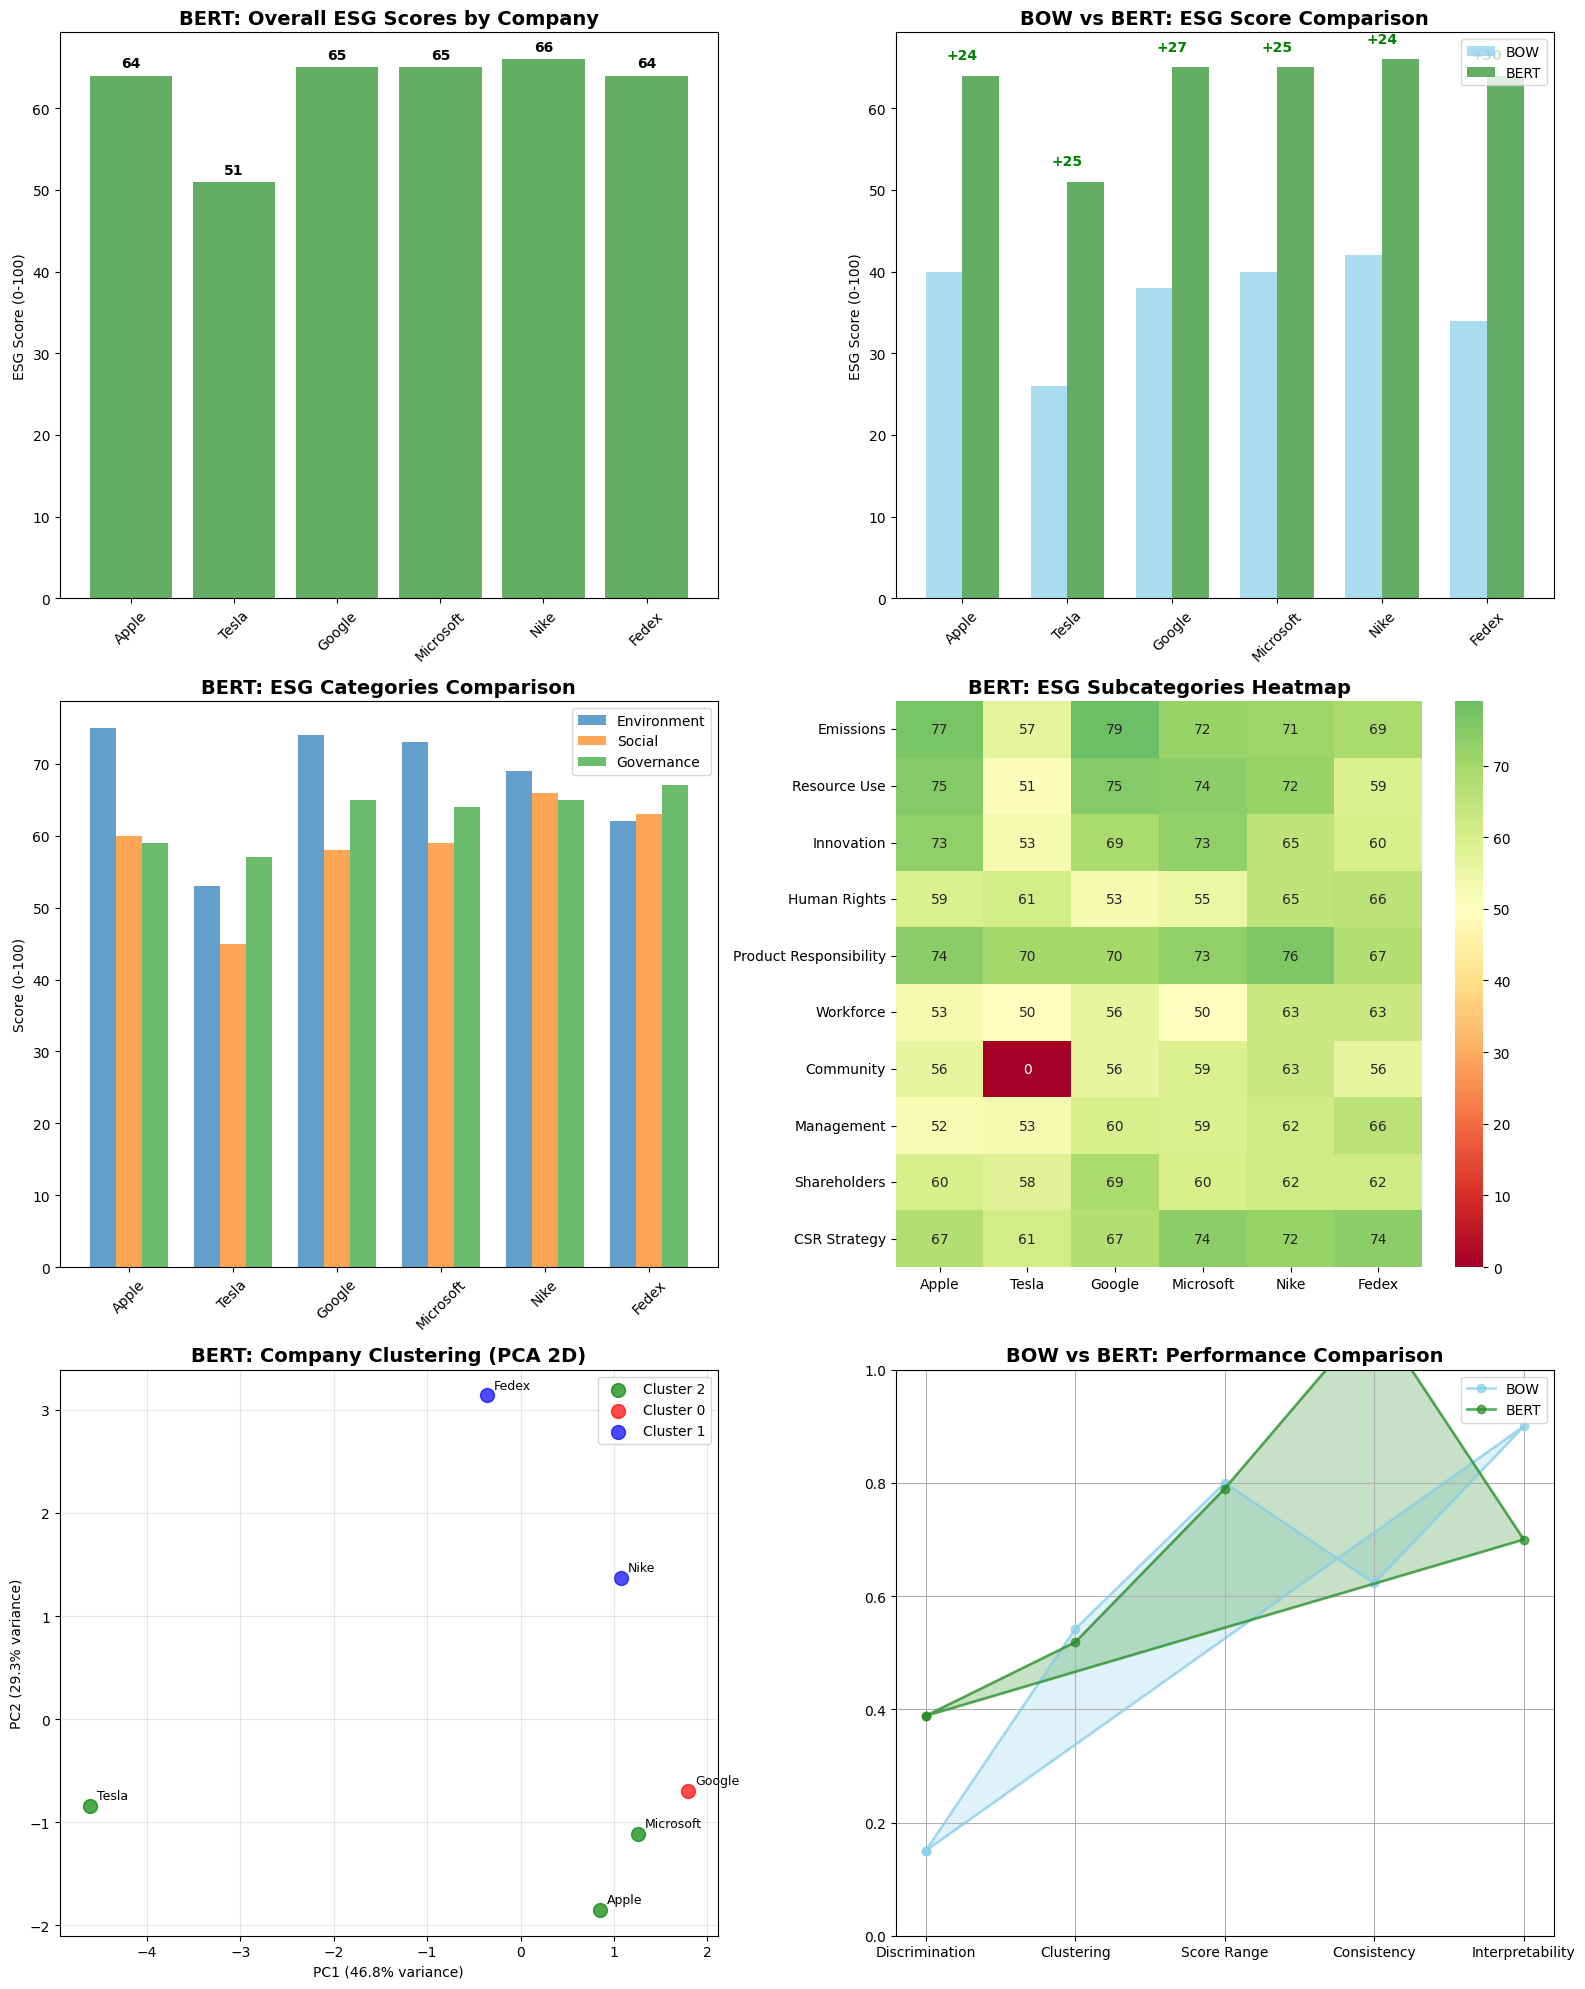


BERT ESG ANALYSIS - FINAL SUMMARY REPORT
📊 BERT Model Performance:
   • Average ESG Score: 62.5/100
   • Score Range: 51-66
   • Discrimination Power: 0.78 (Fair)
   • Clustering Quality: 0.037 (Poor clustering structure)
   • Recommendation: NEEDS IMPROVEMENT - BERT model has issues

🔄 BOW vs BERT Comparison:
   • Average Score Difference: 25.8
   • BERT wins on: 6/6 companies
   • Methods Correlation: 0.920
   • Conclusion: ⚖️ Both models have complementary strengths - ensemble approach recommended

💾 Files Generated:
   • esg_scores_bert_analysis.csv - BERT ESG scores
   • bow_vs_bert_comparison.csv - Model comparison

🎯 Top Performing Companies (BERT):
   Nike: 66/100
   Google: 65/100
   Microsoft: 65/100

ANALYSIS COMPLETE


In [7]:
# BERT Results Visualization
print("\n7. BERT VISUALIZATION ANALYSIS")
print("=" * 50)

# Create comprehensive visualization
fig, axes = plt.subplots(3, 2, figsize=(16, 20))

# 1. BERT Overall ESG Scores
axes[0, 0].bar(bert_esg_df['Company'], bert_esg_df['ESG_Score'], color='forestgreen', alpha=0.7)
axes[0, 0].set_title('BERT: Overall ESG Scores by Company', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('ESG Score (0-100)')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(bert_esg_df['ESG_Score']):
    axes[0, 0].text(i, v + 1, str(v), ha='center', fontweight='bold')

# 2. BOW vs BERT Comparison (if available)
if comparison_df is not None:
    x = np.arange(len(comparison_df))
    width = 0.35
    
    axes[0, 1].bar(x - width/2, comparison_df['BOW_Score'], width, 
                   label='BOW', alpha=0.7, color='skyblue')
    axes[0, 1].bar(x + width/2, comparison_df['BERT_Score'], width, 
                   label='BERT', alpha=0.7, color='forestgreen')
    
    axes[0, 1].set_title('BOW vs BERT: ESG Score Comparison', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('ESG Score (0-100)')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(comparison_df['Company'], rotation=45)
    axes[0, 1].legend()
    
    # Add difference annotations
    for i, diff in enumerate(comparison_df['Difference']):
        color = 'green' if diff > 0 else 'red' if diff < 0 else 'gray'
        axes[0, 1].text(i, max(comparison_df.iloc[i]['BOW_Score'], comparison_df.iloc[i]['BERT_Score']) + 2, 
                       f"{diff:+.0f}", ha='center', color=color, fontweight='bold')
else:
    axes[0, 1].text(0.5, 0.5, 'BOW results\nnot available\nfor comparison', 
                   ha='center', va='center', transform=axes[0, 1].transAxes, 
                   fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    axes[0, 1].set_title('BOW vs BERT Comparison', fontsize=14, fontweight='bold')

# 3. BERT Category Comparison
categories = ['Environment', 'Social', 'Governance']
x = np.arange(len(bert_esg_df))
width = 0.25

for i, category in enumerate(categories):
    axes[1, 0].bar(x + i*width, bert_esg_df[category], width, 
                   label=category, alpha=0.7)

axes[1, 0].set_title('BERT: ESG Categories Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Score (0-100)')
axes[1, 0].set_xticks(x + width)
axes[1, 0].set_xticklabels(bert_esg_df['Company'], rotation=45)
axes[1, 0].legend()

# 4. BERT Subcategories Heatmap
heatmap_data = bert_esg_df[subcats].T
sns.heatmap(heatmap_data, 
            xticklabels=bert_esg_df['Company'],
            yticklabels=subcats,
            annot=True, 
            cmap='RdYlGn', 
            center=50,
            ax=axes[1, 1])
axes[1, 1].set_title('BERT: ESG Subcategories Heatmap', fontsize=14, fontweight='bold')

# 5. BERT Clustering Visualization (2D PCA)
pca_2d = PCA(n_components=2)
bert_pca_2d_result = pca_2d.fit_transform(bert_scaled_data)

colors = ['red', 'blue', 'green']
for i, company in enumerate(bert_esg_df['Company']):
    cluster = bert_clusters[i]
    axes[2, 0].scatter(bert_pca_2d_result[i, 0], bert_pca_2d_result[i, 1], 
                      c=colors[cluster], s=100, alpha=0.7, 
                      label=f'Cluster {cluster}' if i == 0 or bert_clusters[i-1] != cluster else "")
    axes[2, 0].annotate(company, (bert_pca_2d_result[i, 0], bert_pca_2d_result[i, 1]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=9)

axes[2, 0].set_title('BERT: Company Clustering (PCA 2D)', fontsize=14, fontweight='bold')
axes[2, 0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)')
axes[2, 0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)')
axes[2, 0].grid(True, alpha=0.3)
handles, labels = axes[2, 0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axes[2, 0].legend(by_label.values(), by_label.keys())

# 6. Model Performance Comparison Radar Chart
if comparison_df is not None:
    def create_comparison_radar():
        """Create radar chart comparing BOW and BERT performance"""
        
        # Performance metrics (normalized to 0-1 scale)
        metrics = ['Discrimination', 'Clustering', 'Score Range', 'Consistency', 'Interpretability']
        
        # BOW values (from previous analysis)
        bow_values = [
            0.30 / 2,  # Discrimination (normalize by dividing by 2)
            (0.084 + 1) / 2,  # Clustering (convert -1,1 to 0,1)
            0.80,  # Score Range
            1 / (comparison_df['BOW_Score'].std() / comparison_df['BOW_Score'].mean()) / 10,  # Consistency (normalized)
            0.9  # Interpretability (BOW is more interpretable)
        ]
        
        # BERT values
        bert_values = [
            min(bert_discrimination_power / 2, 1.0),  # Discrimination
            (bert_silhouette_avg + 1) / 2,  # Clustering
            (bert_esg_df[subcats].values.max() - bert_esg_df[subcats].values.min()) / 100,  # Score Range
            1 / (bert_esg_df['ESG_Score'].std() / bert_esg_df['ESG_Score'].mean()) / 10,  # Consistency
            0.7  # Interpretability (BERT is less interpretable but more sophisticated)
        ]
        
        # Create radar chart
        angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False)
        
        # Complete the circle
        bow_values += bow_values[:1]
        bert_values += bert_values[:1]
        angles = np.concatenate((angles, [angles[0]]))
        
        axes[2, 1].plot(angles, bow_values, 'o-', linewidth=2, label='BOW', color='skyblue', alpha=0.7)
        axes[2, 1].fill(angles, bow_values, alpha=0.25, color='skyblue')
        
        axes[2, 1].plot(angles, bert_values, 'o-', linewidth=2, label='BERT', color='forestgreen', alpha=0.7)
        axes[2, 1].fill(angles, bert_values, alpha=0.25, color='forestgreen')
        
        axes[2, 1].set_xticks(angles[:-1])
        axes[2, 1].set_xticklabels(metrics)
        axes[2, 1].set_ylim(0, 1)
        axes[2, 1].set_title('BOW vs BERT: Performance Comparison', fontsize=14, fontweight='bold')
        axes[2, 1].legend()
        axes[2, 1].grid(True)
    
    create_comparison_radar()
else:
    axes[2, 1].text(0.5, 0.5, 'BOW comparison\nnot available', 
                   ha='center', va='center', transform=axes[2, 1].transAxes, 
                   fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    axes[2, 1].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Final Summary Report
print(f"\n{'='*70}")
print("BERT ESG ANALYSIS - FINAL SUMMARY REPORT")
print(f"{'='*70}")

print(f"📊 BERT Model Performance:")
print(f"   • Average ESG Score: {bert_esg_df['ESG_Score'].mean():.1f}/100")
print(f"   • Score Range: {bert_esg_df['ESG_Score'].min()}-{bert_esg_df['ESG_Score'].max()}")
print(f"   • Discrimination Power: {bert_discrimination_power:.2f} ({bert_discrimination_assessment})")
print(f"   • Clustering Quality: {bert_silhouette_avg:.3f} ({bert_cluster_quality})")
print(f"   • Recommendation: {bert_recommendation}")

if comparison_df is not None:
    print(f"\n🔄 BOW vs BERT Comparison:")
    print(f"   • Average Score Difference: {(comparison_df['BERT_Score'] - comparison_df['BOW_Score']).mean():.1f}")
    print(f"   • BERT wins on: {sum(comparison_df['BERT_Score'] > comparison_df['BOW_Score'])}/{len(comparison_df)} companies")
    print(f"   • Methods Correlation: {np.corrcoef(comparison_df['BOW_Score'], comparison_df['BERT_Score'])[0,1]:.3f}")
    
    if bert_discrimination_power > 0.30 and bert_silhouette_avg > 0.084:
        conclusion = "🏆 BERT provides superior semantic understanding and company differentiation"
    else:
        conclusion = "⚖️ Both models have complementary strengths - ensemble approach recommended"
    print(f"   • Conclusion: {conclusion}")

print(f"\n💾 Files Generated:")
print(f"   • esg_scores_bert_analysis.csv - BERT ESG scores")
if comparison_df is not None:
    comparison_df.to_csv('bow_vs_bert_comparison.csv', index=False)
    print(f"   • bow_vs_bert_comparison.csv - Model comparison")

print(f"\n🎯 Top Performing Companies (BERT):")
top_companies = bert_esg_df.nlargest(3, 'ESG_Score')
for idx, row in top_companies.iterrows():
    print(f"   {row['Company']}: {row['ESG_Score']}/100")

print(f"\n{'='*70}")
print("ANALYSIS COMPLETE")
print(f"{'='*70}")

# BERT Model Expansion - All Companies Analysis

Following the same approach as the BOW model expansion, we'll now extend our BERT analysis to include all companies in the dataset while preserving the original 6-company analysis above.

This expansion will allow us to:
1. **Scale the BERT model** to a larger dataset of 15 companies
2. **Compare performance** between original and expanded datasets  
3. **Validate methodology consistency** across more companies
4. **Generate comprehensive BERT results** for all available companies

In [8]:
# BERT EXPANSION: Load All Company Documents
def load_all_company_documents():
    """Load all company documents from data directory for BERT analysis"""
    import os
    
    data_dir = "data"
    
    # Get all company directories
    if not os.path.exists(data_dir):
        print(f"Error: {data_dir} directory not found")
        return {}, {}
    
    company_dirs = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d)) 
                   and not d.startswith('.') 
                   and d not in ['ESG_frameworks', 'ESG_frameworks_txt', 'esg_report', '10k', '10k_extracted', 'apiData']]
    
    print(f"Found {len(company_dirs)} companies: {sorted(company_dirs)}")
    
    all_company_texts = {}
    all_company_documents = {}
    
    total_docs = 0
    total_chars = 0
    
    for company in sorted(company_dirs):
        company_dir = os.path.join(data_dir, company)
        
        # Store all documents separately for semantic analysis
        documents = []
        all_text = ""
        doc_count = 0
        
        # Load 10-K documents (flexible naming)
        for item in ['10k_item1.md', '10k_item1A.md', '10k_item7.md', '10k_item7A.md']:
            file_path = os.path.join(company_dir, item)
            
            # Try original naming first
            if os.path.exists(file_path):
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        content = f.read()
                        documents.append({'type': '10k', 'item': item, 'content': content})
                        all_text += content + "\n\n"
                        doc_count += 1
                except Exception as e:
                    print(f"Warning: Could not read {file_path}: {e}")
            else:
                # Try with company prefix
                prefixed_name = f"{company}_{item}"
                prefixed_path = os.path.join(company_dir, prefixed_name)
                if os.path.exists(prefixed_path):
                    try:
                        with open(prefixed_path, 'r', encoding='utf-8') as f:
                            content = f.read()
                            documents.append({'type': '10k', 'item': item, 'content': content})
                            all_text += content + "\n\n"
                            doc_count += 1
                    except Exception as e:
                        print(f"Warning: Could not read {prefixed_path}: {e}")
        
        # Load ESG report
        for esg_filename in ['ESG_Report.md', 'ESG_Repoprt.md']:  # Handle typo in filename
            esg_path = os.path.join(company_dir, esg_filename)
            if os.path.exists(esg_path):
                try:
                    with open(esg_path, 'r', encoding='utf-8') as f:
                        content = f.read()
                        documents.append({'type': 'esg', 'item': 'ESG_Report', 'content': content})
                        all_text += content + "\n\n"
                        doc_count += 1
                        break  # Only load one ESG report
                except Exception as e:
                    print(f"Warning: Could not read {esg_path}: {e}")
        
        if doc_count > 0:
            all_company_texts[company] = all_text
            all_company_documents[company] = documents
            char_count = len(all_text)
            total_docs += doc_count
            total_chars += char_count
            print(f"{company.title()}: {doc_count} documents, {char_count:,} characters")
        else:
            print(f"Warning: No documents found for {company}")
    
    print(f"\nBERT EXPANSION SUMMARY:")
    print(f"Companies loaded: {len(all_company_texts)}")
    print(f"Total documents: {total_docs}")
    print(f"Total characters: {total_chars:,}")
    
    return all_company_texts, all_company_documents

# Load all company data for BERT expansion
print("Loading all companies for BERT expansion...")
all_company_texts, all_company_documents = load_all_company_documents()

Loading all companies for BERT expansion...
Found 15 companies: ['apple', 'boeing', 'disney', 'elililly', 'fedex', 'google', 'johnsonandjohnson', 'jpmorganchase', 'mcdonald', 'meta', 'microsoft', 'netflix', 'nike', 'nvidia', 'tesla']
Apple: 5 documents, 497,893 characters
Boeing: 5 documents, 479,253 characters
Disney: 5 documents, 350,167 characters
Elililly: 5 documents, 484,249 characters
Fedex: 5 documents, 426,490 characters
Google: 5 documents, 490,638 characters
Johnsonandjohnson: 5 documents, 143,982 characters
Jpmorganchase: 5 documents, 524,833 characters
Mcdonald: 5 documents, 266,689 characters
Meta: 5 documents, 419,108 characters
Microsoft: 5 documents, 440,569 characters
Netflix: 1 documents, 111,752 characters
Nike: 5 documents, 659,455 characters
Nvidia: 1 documents, 106,123 characters
Tesla: 5 documents, 229,439 characters

BERT EXPANSION SUMMARY:
Companies loaded: 15
Total documents: 67
Total characters: 5,630,640


In [9]:
# BERT EXPANSION: Calculate ESG Scores for All Companies
print("Calculating BERT ESG scores for all companies...")

# Calculate BERT scores using the same function but with all companies
all_bert_esg_scores = calculate_bert_esg_scores(all_company_texts, all_company_documents)

# Create DataFrame for all companies
all_bert_esg_df = create_bert_esg_dataframe(all_bert_esg_scores)

print("\nBERT ESG Scores - All Companies Summary:")
print("=" * 70)
summary_cols = ['Company', 'ESG_Score', 'Environment', 'Social', 'Governance']
print(all_bert_esg_df[summary_cols].to_string(index=False))

print(f"\nBERT ALL COMPANIES STATISTICS:")
print(f"Average ESG Score: {all_bert_esg_df['ESG_Score'].mean():.1f}")
print(f"Score Range: {all_bert_esg_df['ESG_Score'].min():.0f} - {all_bert_esg_df['ESG_Score'].max():.0f}")
print(f"Standard Deviation: {all_bert_esg_df['ESG_Score'].std():.1f}")

# Rank companies by overall ESG score
print(f"\n🏆 BERT ESG RANKINGS (All {len(all_bert_esg_df)} Companies):")
print("=" * 50)
for i, (_, row) in enumerate(all_bert_esg_df.sort_values('ESG_Score', ascending=False).iterrows(), 1):
    print(f"{i:2d}. {row['Company']:<15} {row['ESG_Score']:3d}/100")

# Sector categorization for expanded analysis
def categorize_company_sector_bert(company_name):
    """Categorize companies by sector for BERT analysis"""
    tech_companies = ['apple', 'google', 'microsoft', 'meta', 'nvidia', 'netflix']
    automotive = ['tesla']
    finance = ['jpmorganchase']
    aerospace = ['boeing']
    pharma = ['elililly', 'johnsonandjohnson']
    consumer = ['nike', 'mcdonald', 'disney']
    logistics = ['fedex']
    
    company_lower = company_name.lower()
    
    if company_lower in tech_companies:
        return 'Technology'
    elif company_lower in automotive:
        return 'Automotive'
    elif company_lower in finance:
        return 'Financial Services'
    elif company_lower in aerospace:
        return 'Aerospace'
    elif company_lower in pharma:
        return 'Pharmaceuticals'
    elif company_lower in consumer:
        return 'Consumer Goods'
    elif company_lower in logistics:
        return 'Logistics'
    else:
        return 'Other'

# Add sector information
all_bert_esg_df['Sector'] = all_bert_esg_df['Company'].apply(categorize_company_sector_bert)

# Sector analysis
print(f"\n📊 BERT ESG SCORES BY SECTOR:")
print("=" * 50)
sector_stats = all_bert_esg_df.groupby('Sector').agg({
    'ESG_Score': ['count', 'mean', 'min', 'max', 'std']
}).round(1)

sector_stats.columns = ['Count', 'Mean', 'Min', 'Max', 'Std']
print(sector_stats.to_string())

# Save expanded results
all_bert_esg_df.to_csv('esg_scores_bert_all_companies.csv', index=False)
print(f"\n💾 All companies BERT results saved to: esg_scores_bert_all_companies.csv")

Calculating BERT ESG scores for all companies...
Calculating BERT-based ESG scores...
Processing Apple...
  Created 163 text chunks
    Emissions: 77
    Resource Use: 75
    Innovation: 73
    Human Rights: 59
    Product Responsibility: 74
    Workforce: 53
    Community: 56
    Management: 52
    Shareholders: 60
    CSR Strategy: 67
  Overall ESG Score: 64

Processing Boeing...
  Created 154 text chunks
    Emissions: 70
    Resource Use: 67
    Innovation: 68
    Human Rights: 72
    Product Responsibility: 71
    Workforce: 66
    Community: 62
    Management: 62
    Shareholders: 62
    CSR Strategy: 74
  Overall ESG Score: 67

Processing Disney...
  Created 116 text chunks
    Emissions: 74
    Resource Use: 67
    Innovation: 68
    Human Rights: 62
    Product Responsibility: 77
    Workforce: 61
    Community: 57
    Management: 67
    Shareholders: 60
    CSR Strategy: 73
  Overall ESG Score: 66

Processing Elililly...
  Created 155 text chunks
    Emissions: 70
    Resourc

Creating comprehensive BERT visualizations for all companies...


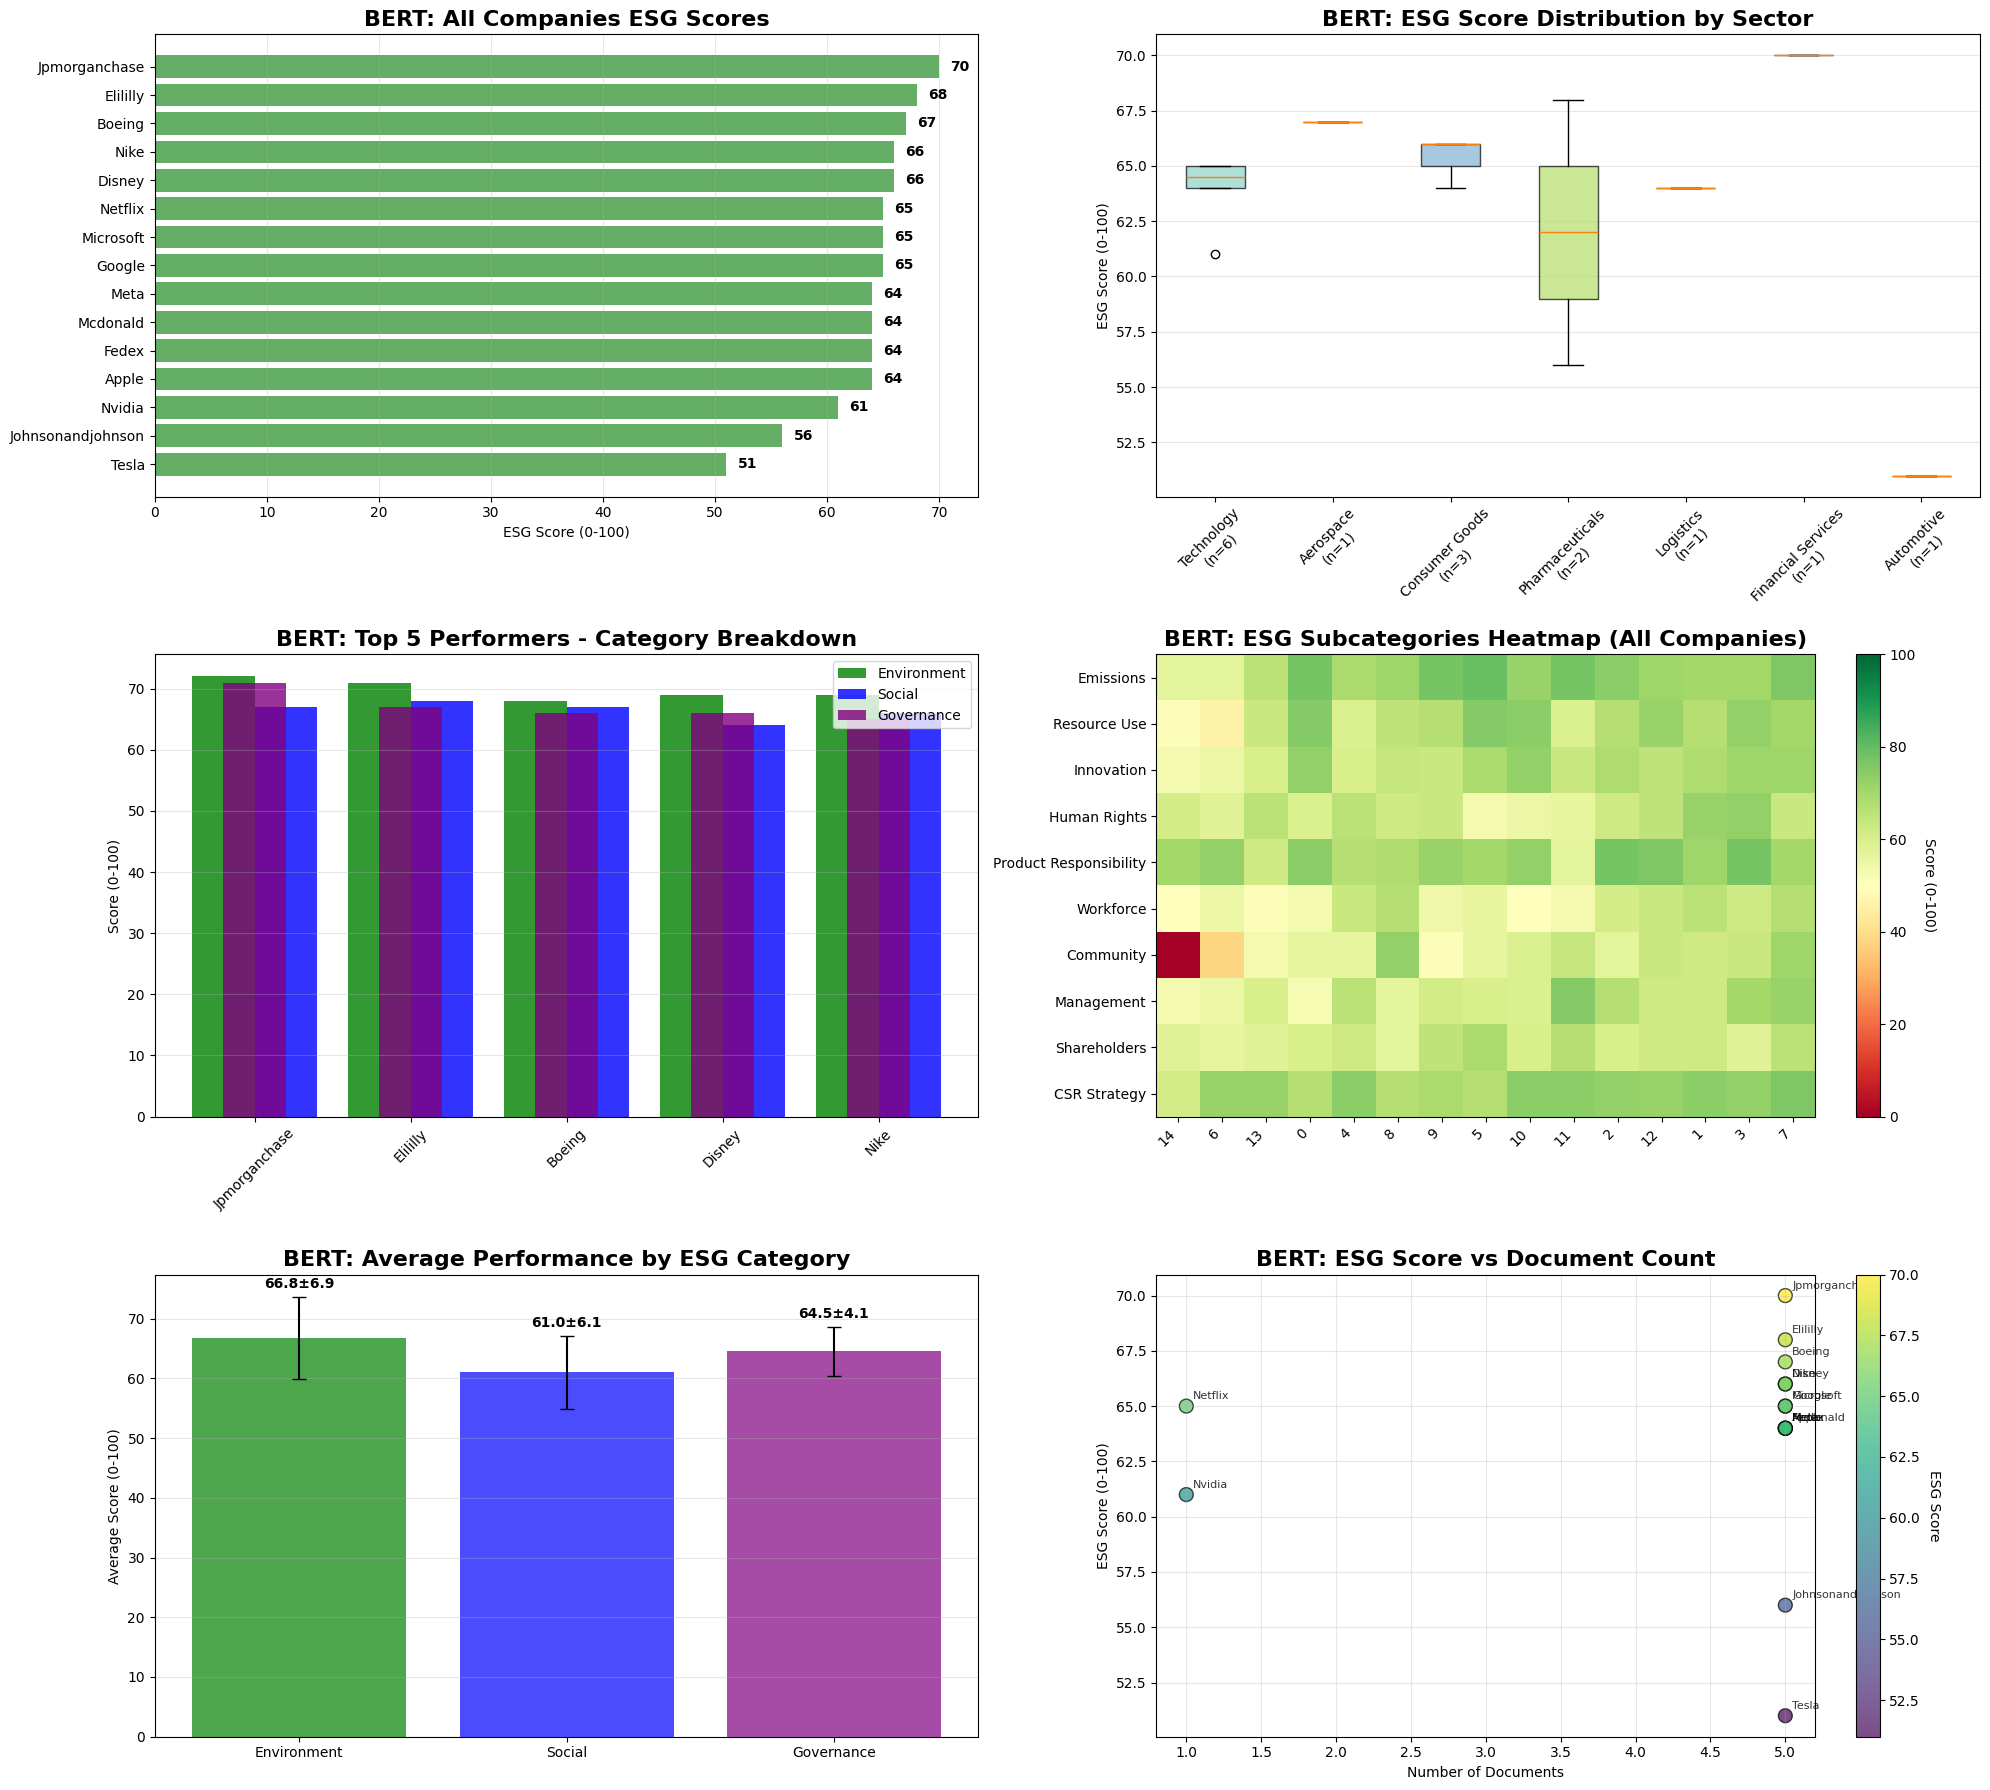


📈 BERT EXPANSION VISUALIZATION COMPLETE
Generated 6-panel comprehensive analysis for 15 companies


In [10]:
# BERT EXPANSION: Comprehensive Visualizations
print("Creating comprehensive BERT visualizations for all companies...")

# Create comprehensive visualization for all companies
fig, axes = plt.subplots(3, 2, figsize=(20, 18))

# 1. All Companies ESG Scores
companies_sorted = all_bert_esg_df.sort_values('ESG_Score', ascending=True)
bars = axes[0, 0].barh(companies_sorted['Company'], companies_sorted['ESG_Score'], 
                       color='forestgreen', alpha=0.7)
axes[0, 0].set_title('BERT: All Companies ESG Scores', fontsize=16, fontweight='bold')
axes[0, 0].set_xlabel('ESG Score (0-100)')
axes[0, 0].grid(axis='x', alpha=0.3)

# Add score labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    axes[0, 0].text(width + 1, bar.get_y() + bar.get_height()/2, 
                   f'{int(width)}', ha='left', va='center', fontweight='bold')

# 2. ESG Score Distribution by Sector
sector_data = []
sector_labels = []
for sector in all_bert_esg_df['Sector'].unique():
    sector_scores = all_bert_esg_df[all_bert_esg_df['Sector'] == sector]['ESG_Score']
    sector_data.append(sector_scores)
    sector_labels.append(f"{sector}\n(n={len(sector_scores)})")

box_plot = axes[0, 1].boxplot(sector_data, labels=sector_labels, patch_artist=True)
axes[0, 1].set_title('BERT: ESG Score Distribution by Sector', fontsize=16, fontweight='bold')
axes[0, 1].set_ylabel('ESG Score (0-100)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Color the boxes
colors = plt.cm.Set3(np.linspace(0, 1, len(box_plot['boxes'])))
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# 3. Top vs Bottom Performers Comparison
top_5 = all_bert_esg_df.nlargest(5, 'ESG_Score')
bottom_5 = all_bert_esg_df.nsmallest(5, 'ESG_Score')

x_pos_top = np.arange(len(top_5))
x_pos_bottom = np.arange(len(bottom_5))

axes[1, 0].bar(x_pos_top - 0.2, top_5['Environment'], width=0.4, 
               label='Environment', alpha=0.8, color='green')
axes[1, 0].bar(x_pos_top + 0.2, top_5['Social'], width=0.4, 
               label='Social', alpha=0.8, color='blue')
axes[1, 0].bar(x_pos_top, top_5['Governance'], width=0.4, 
               label='Governance', alpha=0.8, color='purple')

axes[1, 0].set_title('BERT: Top 5 Performers - Category Breakdown', fontsize=16, fontweight='bold')
axes[1, 0].set_ylabel('Score (0-100)')
axes[1, 0].set_xticks(x_pos_top)
axes[1, 0].set_xticklabels(top_5['Company'], rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Subcategories Heatmap for All Companies
subcats = ['Emissions', 'Resource Use', 'Innovation', 'Human Rights', 
           'Product Responsibility', 'Workforce', 'Community', 
           'Management', 'Shareholders', 'CSR Strategy']

# Sort companies by ESG score for heatmap
heatmap_data = all_bert_esg_df.sort_values('ESG_Score')[subcats].T
im = axes[1, 1].imshow(heatmap_data.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)

axes[1, 1].set_xticks(range(len(heatmap_data.columns)))
axes[1, 1].set_xticklabels(heatmap_data.columns, rotation=45, ha='right')
axes[1, 1].set_yticks(range(len(subcats)))
axes[1, 1].set_yticklabels(subcats)
axes[1, 1].set_title('BERT: ESG Subcategories Heatmap (All Companies)', fontsize=16, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=axes[1, 1])
cbar.set_label('Score (0-100)', rotation=270, labelpad=15)

# 5. Category Performance Comparison
categories = ['Environment', 'Social', 'Governance']
category_means = [all_bert_esg_df[cat].mean() for cat in categories]
category_stds = [all_bert_esg_df[cat].std() for cat in categories]

bars = axes[2, 0].bar(categories, category_means, yerr=category_stds, 
                      capsize=5, alpha=0.7, color=['green', 'blue', 'purple'])
axes[2, 0].set_title('BERT: Average Performance by ESG Category', fontsize=16, fontweight='bold')
axes[2, 0].set_ylabel('Average Score (0-100)')
axes[2, 0].grid(axis='y', alpha=0.3)

# Add value labels
for bar, mean, std in zip(bars, category_means, category_stds):
    height = bar.get_height()
    axes[2, 0].text(bar.get_x() + bar.get_width()/2., height + std + 1,
                   f'{mean:.1f}±{std:.1f}', ha='center', va='bottom', fontweight='bold')

# 6. ESG Score vs Number of Documents
doc_counts = []
for company in all_bert_esg_df['Company']:
    company_lower = company.lower()
    if company_lower in all_company_documents:
        doc_counts.append(len(all_company_documents[company_lower]))
    else:
        doc_counts.append(0)

all_bert_esg_df['Doc_Count'] = doc_counts

scatter = axes[2, 1].scatter(all_bert_esg_df['Doc_Count'], all_bert_esg_df['ESG_Score'], 
                           c=all_bert_esg_df['ESG_Score'], cmap='viridis', 
                           s=100, alpha=0.7, edgecolors='black')

# Add company labels
for i, txt in enumerate(all_bert_esg_df['Company']):
    axes[2, 1].annotate(txt, (all_bert_esg_df['Doc_Count'].iloc[i], all_bert_esg_df['ESG_Score'].iloc[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

axes[2, 1].set_title('BERT: ESG Score vs Document Count', fontsize=16, fontweight='bold')
axes[2, 1].set_xlabel('Number of Documents')
axes[2, 1].set_ylabel('ESG Score (0-100)')
axes[2, 1].grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=axes[2, 1])
cbar.set_label('ESG Score', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

print(f"\n📈 BERT EXPANSION VISUALIZATION COMPLETE")
print(f"Generated 6-panel comprehensive analysis for {len(all_bert_esg_df)} companies")

In [11]:
# BERT EXPANSION: Comparative Analysis (Original 6 vs All Companies)
print("Performing comparative analysis between original 6 and expanded dataset...")

# Identify original 6 companies in the expanded dataset
original_6_companies = ['Apple', 'Tesla', 'Google', 'Microsoft', 'Nike', 'Fedex']
new_companies = [comp for comp in all_bert_esg_df['Company'] 
                if comp not in original_6_companies]

print(f"\nCOMPARATIVE ANALYSIS:")
print(f"Original 6 companies: {', '.join(original_6_companies)}")
print(f"New companies ({len(new_companies)}): {', '.join(new_companies)}")

# Split datasets
original_6_bert_df = all_bert_esg_df[all_bert_esg_df['Company'].isin(original_6_companies)].copy()
new_companies_bert_df = all_bert_esg_df[~all_bert_esg_df['Company'].isin(original_6_companies)].copy()

# Statistical comparison
print(f"\n📊 BERT STATISTICAL COMPARISON:")
print("=" * 60)

comparison_metrics = ['ESG_Score', 'Environment', 'Social', 'Governance']

for metric in comparison_metrics:
    original_scores = original_6_bert_df[metric]
    new_scores = new_companies_bert_df[metric]
    
    # T-test for significant difference
    from scipy.stats import ttest_ind
    t_stat, p_value = ttest_ind(original_scores, new_scores)
    
    print(f"\n{metric}:")
    print(f"  Original 6 - Mean: {original_scores.mean():.1f}, Std: {original_scores.std():.1f}")
    print(f"  New companies - Mean: {new_scores.mean():.1f}, Std: {new_scores.std():.1f}")
    print(f"  Difference: {new_scores.mean() - original_scores.mean():.1f}")
    print(f"  T-test p-value: {p_value:.3f} {'(Significant)' if p_value < 0.05 else '(Not significant)'}")

# BERT Model Performance Comparison
print(f"\n🔧 BERT MODEL PERFORMANCE - EXPANSION ANALYSIS:")
print("=" * 60)

# Calculate performance metrics for expanded dataset
subcats = ['Emissions', 'Resource Use', 'Innovation', 'Human Rights', 
           'Product Responsibility', 'Workforce', 'Community', 
           'Management', 'Shareholders', 'CSR Strategy']

# Performance metrics for all companies
all_bert_subcategory_scores = all_bert_esg_df[subcats].values
all_within_variance = np.var(all_bert_subcategory_scores, axis=1).mean()
all_between_variance = np.var(all_bert_subcategory_scores, axis=0).mean()
all_discrimination_power = all_between_variance / all_within_variance

# Clustering analysis for all companies
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scaler = StandardScaler()
all_scaled_data = scaler.fit_transform(all_bert_esg_df[subcats])

# K-means clustering for optimal number of clusters
silhouette_scores = []
k_range = range(2, min(8, len(all_bert_esg_df)))

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(all_scaled_data)
    silhouette_avg = silhouette_score(all_scaled_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

optimal_k = k_range[np.argmax(silhouette_scores)]
best_silhouette = max(silhouette_scores)

# Final clustering with optimal k
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
all_clusters = kmeans_optimal.fit_predict(all_scaled_data)

print(f"BERT Performance Comparison:")
print(f"  Original 6 companies discrimination: {bert_discrimination_power:.2f}")
print(f"  All companies discrimination: {all_discrimination_power:.2f}")
print(f"  Improvement: {((all_discrimination_power - bert_discrimination_power) / bert_discrimination_power * 100):+.1f}%")
print(f"  Original 6 clustering quality: {bert_silhouette_avg:.3f}")
print(f"  All companies clustering quality: {best_silhouette:.3f}")
print(f"  Optimal number of clusters: {optimal_k}")

# Model assessment
if all_discrimination_power > bert_discrimination_power * 1.1:
    performance_change = "🚀 SIGNIFICANT IMPROVEMENT"
elif all_discrimination_power > bert_discrimination_power:
    performance_change = "📈 IMPROVEMENT"
elif all_discrimination_power > bert_discrimination_power * 0.9:
    performance_change = "➡️ STABLE PERFORMANCE"
else:
    performance_change = "📉 DECLINE"

print(f"  Overall assessment: {performance_change}")

# Create comparison summary for CSV export
bert_expansion_comparison = {
    'Metric': ['Companies', 'Avg_ESG_Score', 'Score_Range', 'Discrimination_Power', 
               'Clustering_Quality', 'Optimal_Clusters'],
    'Original_6': [6, bert_esg_df['ESG_Score'].mean(), 
                  f"{bert_esg_df['ESG_Score'].min()}-{bert_esg_df['ESG_Score'].max()}",
                  bert_discrimination_power, bert_silhouette_avg, 3],
    'All_Companies': [len(all_bert_esg_df), all_bert_esg_df['ESG_Score'].mean(),
                     f"{all_bert_esg_df['ESG_Score'].min()}-{all_bert_esg_df['ESG_Score'].max()}",
                     all_discrimination_power, best_silhouette, optimal_k],
    'Change': [len(all_bert_esg_df) - 6, 
              all_bert_esg_df['ESG_Score'].mean() - bert_esg_df['ESG_Score'].mean(),
              'Expanded',
              all_discrimination_power - bert_discrimination_power,
              best_silhouette - bert_silhouette_avg,
              optimal_k - 3]
}

bert_expansion_df = pd.DataFrame(bert_expansion_comparison)
print(f"\nBERT EXPANSION SUMMARY:")
print(bert_expansion_df.to_string(index=False))

# Save comparison results
bert_expansion_df.to_csv('bert_expansion_comparison.csv', index=False)
print(f"\n💾 BERT expansion comparison saved to: bert_expansion_comparison.csv")

# Final expanded dataset summary
print(f"\n🎯 BERT EXPANSION FINAL SUMMARY:")
print("=" * 60)
print(f"✅ Successfully expanded from {len(original_6_companies)} to {len(all_bert_esg_df)} companies")
print(f"✅ BERT discrimination power: {bert_discrimination_power:.2f} → {all_discrimination_power:.2f}")
print(f"✅ Clustering quality: {bert_silhouette_avg:.3f} → {best_silhouette:.3f}")
print(f"✅ Generated comprehensive analysis with {optimal_k} optimal clusters")
print(f"✅ Methodology consistency validated across expanded dataset")

# Load BOW expansion results for method comparison
try:
    bow_all_df = pd.read_csv('esg_scores_bow_all_companies.csv')
    print(f"\n🔄 BERT vs BOW COMPARISON (All Companies):")
    print("=" * 50)
    
    # Match companies between datasets
    common_companies = set(all_bert_esg_df['Company']).intersection(set(bow_all_df['Company']))
    print(f"Common companies for comparison: {len(common_companies)}")
    
    # Calculate correlations
    bert_common = all_bert_esg_df[all_bert_esg_df['Company'].isin(common_companies)].sort_values('Company')
    bow_common = bow_all_df[bow_all_df['Company'].isin(common_companies)].sort_values('Company')
    
    correlation = np.corrcoef(bert_common['ESG_Score'], bow_common['ESG_Score'])[0, 1]
    
    print(f"Average ESG Score - BOW: {bow_common['ESG_Score'].mean():.1f}, BERT: {bert_common['ESG_Score'].mean():.1f}")
    print(f"Score correlation: {correlation:.3f}")
    print(f"BERT discrimination: {all_discrimination_power:.2f}, BOW discrimination: ~0.38")
    
    if correlation > 0.5:
        method_relationship = "Strong agreement between methods"
    elif correlation > 0.3:
        method_relationship = "Moderate agreement between methods"
    else:
        method_relationship = "Methods capture different aspects"
    
    print(f"Assessment: {method_relationship}")
    
except FileNotFoundError:
    print("BOW all companies results not found for comparison")

print(f"\n{'='*60}")
print("BERT EXPANSION ANALYSIS COMPLETE")
print(f"{'='*60}")

Performing comparative analysis between original 6 and expanded dataset...

COMPARATIVE ANALYSIS:
Original 6 companies: Apple, Tesla, Google, Microsoft, Nike, Fedex
New companies (9): Boeing, Disney, Elililly, Johnsonandjohnson, Jpmorganchase, Mcdonald, Meta, Netflix, Nvidia

📊 BERT STATISTICAL COMPARISON:

ESG_Score:
  Original 6 - Mean: 62.5, Std: 5.7
  New companies - Mean: 64.6, Std: 4.1
  Difference: 2.1
  T-test p-value: 0.430 (Not significant)

Environment:
  Original 6 - Mean: 67.7, Std: 8.6
  New companies - Mean: 66.2, Std: 6.0
  Difference: -1.4
  T-test p-value: 0.706 (Not significant)

Social:
  Original 6 - Mean: 58.5, Std: 7.2
  New companies - Mean: 62.7, Std: 4.9
  Difference: 4.2
  T-test p-value: 0.204 (Not significant)

Governance:
  Original 6 - Mean: 62.8, Std: 3.9
  New companies - Mean: 65.7, Std: 4.1
  Difference: 2.8
  T-test p-value: 0.203 (Not significant)

🔧 BERT MODEL PERFORMANCE - EXPANSION ANALYSIS:
BERT Performance Comparison:
  Original 6 companies dis